In [1]:
# Import packages
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Import packages
%reset -f
from tqdm import tqdm
import numpy as np
import pprint
import os
import gzip
import torch
import torchvision
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [3]:
def load_mnist(path, kind='train'):
    '''
    Load MNIST data from specified path
    '''
    
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte.gz'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte.gz'
                               % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    return images, labels

In [4]:
def _filter(xs, ys, lbls):
    '''
    Filter observations to construct relevant dataset
    '''
    idxs = [i for (i, l) in enumerate(ys) if l in lbls]
    return xs[idxs, :], ys[idxs]

In [5]:
def clear_gpu(model):
   '''
   Removes model from GPU and clears memory
   '''
   model = model.to('cpu')
   del model
   torch.cuda.empty_cache()

In [8]:
class Dataset(torch.utils.data.Dataset):
    '''
    Basic dataset class to work with Torch data loader
    '''
    def __init__(self, X, y):
        self.X = X
        self.y = y
        
        # No. of rows in feature array should equal no. of examples
        assert len(X) == len(y), print("Number of examples don't match up")

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return self.X[index], self.y[index]

In [9]:
class Net(torch.nn.Module):
  '''
  Basic convolutional neural network class
  '''
  def __init__(self):
    '''
    Architecture definition
    '''
    super(Net, self).__init__()
    self.conv1 = torch.nn.Conv2d(1, 6, kernel_size=3, stride=1, padding=1)
    self.pool = torch.nn.MaxPool2d(2, 2)
    self.conv2 = torch.nn.Conv2d(6, 16, 5)
    self.fc1 = torch.nn.Linear(16 * 5 * 5, 120)
    self.fc2 = torch.nn.Linear(120, 84)
    self.fc3 = torch.nn.Linear(84, 5)
    
  def forward(self, x):
    '''
    Forward propagation
    '''
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(-1, 16 * 5 * 5)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x) 
    
    return x

In [10]:
  def get_data(dataloader_params, path='/content/drive/MyDrive/data'): 
    '''
    Prepare data
    '''
    # Load data
    train_images, train_labels = load_mnist(path, 'train')
    test_images, test_labels = load_mnist(path, 't10k')
    
    # Validation images
    val_images = train_images[50000:]
    val_labels = train_labels[50000:]
    
    # Train images
    train_images = train_images[:50000]
    train_labels = train_labels[:50000]
    
    # Filter the relevant images according to the problem specification
    X_train, Y_train = _filter(train_images, train_labels, [0, 1, 4, 5, 8])
    X_val, Y_val = _filter(val_images, val_labels, [0, 1, 4, 5, 8])
    X_test, Y_test = _filter(test_images, test_labels, [0, 1, 4, 5, 8])

    for Y in [Y_train, Y_val, Y_test]:
      Y[Y == 4] =  2
      Y[Y == 5] =  3
      Y[Y == 8] =  4
    
    # Reshape data into 28 X 28 format
    X_train = X_train.reshape(X_train.shape[0], 28, 28)
    X_test = X_test.reshape(X_test.shape[0], 28, 28)
    X_val = X_val.reshape(X_val.shape[0], 28, 28)
    
    # Add new axis to to make sure 
    X_train = X_train[:, np.newaxis, :, :]
    X_test = X_test[:, np.newaxis, :, :]
    X_val = X_val[:, np.newaxis, :, :]
    
    # Dataset
    train_data = Dataset(X_train, Y_train)
    train_generator = torch.utils.data.DataLoader(train_data, **dataloader_params)
    
    # Convert into torch tensors and send to device
    X_train = torch.from_numpy(X_train).type(torch.FloatTensor)
    Y_train = torch.Tensor(Y_train).type(torch.LongTensor)
    
    # Convert into torch tensors and send to device
    X_val = torch.from_numpy(X_val).type(torch.FloatTensor)
    Y_val = torch.Tensor(Y_val).type(torch.LongTensor)
    
    # Convert into torch tensors and send to device
    X_test = torch.from_numpy(X_test).type(torch.FloatTensor)
    Y_test = torch.Tensor(Y_test).type(torch.LongTensor)
    
    # Return statement
    return(train_generator, X_train, Y_train, X_val, Y_val, X_test, Y_test)

In [11]:
def train(question_no, model_num, epochs=30, batch_size=32, lr=0.1, weight_decay=0, test=False):
    '''
    Main training loop for convolutional network
    '''
    # Set the seed so each experiment is reproducible
    np.random.seed(21390)
    torch.manual_seed(10394)

    # Set parameters
    dataloader_params = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 6}
    epochs = epochs
  
    # Store results here
    history = {
        'train_accuracy': [],
        'train_loss': [], 
        'val_accuracy': [],
        'val_loss': []
    }
  
    # Load data
    train_generator, X_train, Y_train, X_val, Y_val, X_test, Y_test = get_data(dataloader_params)
  
    # Set device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # Send all these objects to the relevant device
    X_train = X_train.to(device)
    Y_train = Y_train.to(device)

    # Validation set to GPU
    X_val = X_val.to(device)
    Y_val = Y_val.to(device)

    # Testing set to GPU
    X_test = X_test.to(device)
    Y_test = Y_test.to(device)

    # Create the neural network objects and parameters
    net = Net().to(device)
  
    # Loss function
    loss_fn = torch.nn.CrossEntropyLoss()
    
    # Optimizer
    optimizer = torch.optim.Adam(net.parameters(), lr = lr, weight_decay=weight_decay)


    if not test:
      
        # Train for maximum number of epochs given here
        for epoch in tqdm(range(epochs)):
      
            # Initialize running loss value for this epoch
            running_loss = 0.0
      
            # Loop through the generator containing training images
            for i, data in enumerate(train_generator):

              # Retrieve inputs and labels
              inputs, labels = data

              # Send them to GPU 
              inputs = inputs.type(torch.FloatTensor).to(device)
              labels =  labels.type(torch.LongTensor).to(device)

              # Zero the optimizer gradients
              optimizer.zero_grad()

              # Forward propagation
              outputs = net.forward(inputs)

              # Compute loss
              loss = loss_fn(outputs, labels)
          
              # Backward propogation
              loss.backward()

              # Weight update
              optimizer.step()
      
            # Compute training loss
            with torch.no_grad():
          
              # Forward propagation
              out = net.forward(X_train)

              # Prediction 
              preds = out.argmax(axis=1)

              # Get accuracy 
              accuracy = sum(preds == Y_train)/len(Y_train)
          
              # Get loss 
              loss = loss_fn(out, Y_train)

              print("Train accuracy {}, Train Loss: {}".format(accuracy, loss))

              # Append to history record
              history['train_accuracy'].append(accuracy)
              history['train_loss'].append(loss)

          
            # Compute validation loss
            with torch.no_grad():
        
              # Forward propogation
              out = net.forward(X_val)

              # Prediction 
              preds = out.argmax(axis=1)
        
              # Calculate accuracy
              accuracy = sum(preds == Y_val)/len(Y_val)

              # Calculate loss 
              loss = loss_fn(out, Y_val)

              # Print statement
              print("Val. accuracy {}, Val. Loss:, {}".format(accuracy, loss))
        
              # Append to history record
              history['val_accuracy'].append(accuracy)
              history['val_loss'].append(loss)

            if epoch %5 == 0:
          
              model_state = {
                    'epoch': epoch,
                    'model_state_dict': net.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'history': history
                    }
          
              save_checkpoint(model_state, question_no, model_num)
    

        # Plot and save epoch by epoch results
        plot_results(history, 'loss', model_num=model_num)
        plot_results(history, 'accuracy', model_num=model_num)

        # Return statement
        return(history)
        
    # If the test flag is True we execute this
    if test:

        # First use helper function given below to load checkpoints file
        checkpoint = load_checkpoint(question_no = question_no, model_num=model_num)

        # Load model state dictionary
        net.load_state_dict(checkpoint['model_state_dict'])
        
        # Load optimizer state dictionary
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        
        # Set model to evaluation mode to make sure any batch norm and dropout layers are set correctly
        net.eval()

        # Now do the testing process
        with torch.no_grad():
        
            # Forward propogation
            out = net.forward(X_test)
        
            # Prediction 
            preds = out.argmax(axis=1)
        
            # Calculate accuracy
            accuracy = sum(preds == Y_test)/len(Y_test)
        
            # Calculate loss 
            loss = loss_fn(out, Y_test)

            # Print success message
            print("Testing completed! Saving results now...")

            # Print accuracy 
            print(accuracy)

            # Print losss
            print(loss)
        
            # Append to history record
            checkpoint['test_accuracy'] = accuracy
        
            # Append loss to history record
            checkpoint['test_loss'] = loss

        # Return statement    
        return(preds, Y_test)

In [12]:
def plot_results(history, lab, model_num, path='/content/drive/MyDrive/'):
    '''
    Convenience function to plot results
    '''
    # Construct model name
    model_name = str(model_num) + '_' + lab + '.png'
    path = os.path.join(path, '1_figs', model_name)
    
    # Plot the results
    plt.plot(history['train_' + lab], label='Train')
    plt.plot(history['val_' + lab], label='Validation')
  
    # Add annotations
    plt.legend()
    plt.title(lab.title() + ' by Epoch')
  
    # Save the figure and close the plot
    plt.savefig(path)
    plt.show()
    plt.clf()

In [13]:
def get_results(question_no, model_num):
  '''
  Take in a results dictionary 
  and return epoch on which 
  minimum validation loss was
  reached, minimum val. loss on
  that epoch, and min. accuracy
  on that epoch
  '''
  # Load the trained weights
  checkpoint = load_checkpoint(question_no = question_no, model_num=model_num)

  # Load the history object which contains a record of losses
  history = checkpoint['history'] 

  # Find the epoch on which the minimum validation loss was reached
  best_val_epoch = np.argmin(np.array(history['val_loss']))
  
  # Store validation metrics
  best_epoch_val_loss = np.array(history['val_loss'][best_val_epoch])
  best_epoch_val_accuracy = np.array(history['val_accuracy'][best_val_epoch])

  # Store training metrics
  best_epoch_train_loss = np.array(history['train_loss'][best_val_epoch])
  best_epoch_train_accuracy = np.array(history['train_accuracy'][best_val_epoch])
  
  # Store best results in a list
  results = {'best_val_epoch': best_val_epoch, 
             'best_epoch_val_loss': best_epoch_val_loss, 
             'best_epoch_val_accuracy': best_epoch_val_accuracy, 
             'best_epoch_train_loss': best_epoch_train_loss,
             'best_epoch_train_accuracy': best_epoch_train_accuracy, 
             'final_train_loss': history['train_loss'][-1],
             'final_train_accuracy': history['train_accuracy'][-1],
             'final_val_loss': history['val_loss'][-1], 
             'final_val_accuracy': history['val_accuracy'][-1]}

  # Return statement
  return(results)

In [14]:
def save_checkpoint(model_state, question_no, model_num):
    '''
    Save model state using this function
    '''
    checkpoints_path = '/content/drive/MyDrive/1_checkpoints/{}_{}.pt'.format(question_no, model_num)
    
    torch.save(model_state, checkpoints_path)

In [15]:
def load_checkpoint(question_no, model_num):
    '''
    Save model state using this function
    '''
    # Create checkpoints path
    checkpoints_path = '/content/drive/MyDrive/1_checkpoints/{}_{}.pt'.format(question_no, model_num)

    # Load checkpoint
    checkpoint = torch.load(checkpoints_path)
    
    # Return statement
    return(checkpoint)

In [16]:
from sklearn.metrics import confusion_matrix
import pandas as pd

def get_confusion_matrix(pred_list, lbl_list, question_no, model_num, dest_path='/content/drive/MyDrive/1_results'):
    '''
    Evaluate model on the test set
    '''
    cols = ['T-shirt/top', 'Trouser', 'Coat', 'Sandal', 'Bag']
    rows = ['T-shirt/top', 'Trouser', 'Coat', 'Sandal', 'Bag']

    conf_mat=confusion_matrix(lbl_list.numpy(), pred_list.numpy())
    cf = pd.DataFrame(conf_mat)
    cf.columns = cols 
    cf.index = rows

    cf.to_csv(os.path.join(dest_path, 'confusion_matrix_{}_{}.csv'.format(question_no, model_num)))
    print(cf)
      
    # Print per class accuracy
    class_accuracy=100*conf_mat.diagonal()/conf_mat.sum(1)
    ca = pd.DataFrame(class_accuracy).T

    ca.columns = cols
    ca.index = ['Accuracy']
    
    ca.to_csv(os.path.join(dest_path, 'class_accuracies_{}_{}.csv'.format(question_no, model_num)))
    print(ca)

In [17]:
def execute_train_pipeline(question_no, model_num, test):
    '''
    Execute training for different model objects
    '''
    if model_num == 10:
      results = train(question_no, model_num, lr=0.00001, batch_size=32, epochs=70, weight_decay=0.01, test=test)

    if test:
      
      # First make the confusion matrix
      get_confusion_matrix(*results, question_no, model_num)
      
      # Next store the
      final_results = get_results(question_no, model_num)

      pp = pprint.PrettyPrinter(indent=4)
      pp.pprint(final_results)
      

In [119]:
def get_setup_for_feature_map(question_no = 1, model_num = 10, lr = 0.00001, weight_decay = 0.01):
    '''
    Setup for visualization
    '''
    # Device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # Create net object
    net = Net().to(device)
  
    # Loss function
    loss_fn = torch.nn.CrossEntropyLoss()
    
    # Optimizer
    optimizer = torch.optim.Adam(net.parameters(), lr = lr, weight_decay=weight_decay)

    with torch.no_grad():

      # First use helper function given below to load checkpoints file
      checkpoint = load_checkpoint(question_no = question_no, model_num=model_num)

      # Load model state dictionary
      net.load_state_dict(checkpoint['model_state_dict'])
        
      # Load optimizer state dictionary
      optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

      dataloader_params = {'batch_size': 32, 'shuffle': True, 'num_workers': 6}

      # Load data
      _, _, _, _, _, X_test, Y_test = get_data(dataloader_params)

      model_children = list(net.children())

    return(model_children, X_test, Y_test)

In [120]:
 def extract_conv_layers(model_children):
    '''
    Extract convolutional layers given list of layers
    '''
  
    # Counter to keep count of the conv layers
    counter = 0 
    conv_layers = []
    model_weights = []

    # Append all the conv layers and their respective weights to the list
    for i in range(len(model_children)):
    
        # First get the children of the model which are directly declared as conv. layers
        if type(model_children[i]) == torch.nn.modules.conv.Conv2d:
            counter += 1
            model_weights.append(model_children[i].weight)
            conv_layers.append(model_children[i])

        elif type(model_children[i]) == torch.nn.Sequential:
            for j in range(len(model_children[i])):
                for child in model_children[i][j].children():
                    if type(child) == torch.nn.modules.conv.Conv2d:
                        counter += 1
                        model_weights.append(child.weight)
                        conv_layers.append(child)

    # Print statement
    print(f"Total convolutional layers: {counter}")

    # Return statement
    return(conv_layers, model_weights)

In [121]:
def apply_conv_layers(conv_layers, model_weights, img):
  '''
  Apply the conv layer weights on each batch
  '''
  # Pass the image through all the layers
  results = [conv_layers[0](img)]

  # Loop through the rest of the layers
  for i in range(1, len(conv_layers)):
      # Pass the result from the last layer to the next layer
      results.append(conv_layers[i](results[-1]))
  
  # Make a copy of the `results`
  outputs = results

  # Return statements
  return(outputs)

In [122]:
def show_imgs():
    '''
    Plot images
    '''
    plt.imshow(results[0][0][1].detach().numpy())
    plt.imshow(img[0][0])

In [21]:
# train_results = execute_train_pipeline(question_no=1, model_num=10, test=False)
test_results = execute_train_pipeline(question_no=1, model_num=10, test=True)

Testing completed! Saving results now...
tensor(0.9856)
tensor(0.0470)
             T-shirt/top  Trouser  Coat  Sandal  Bag
T-shirt/top          971        2    14       3   10
Trouser                3      987     8       0    2
Coat                   6        2   990       1    1
Sandal                 0        1     0     998    1
Bag                    9        1     5       3  982
          T-shirt/top  Trouser  Coat  Sandal   Bag
Accuracy         97.1     98.7  99.0    99.8  98.2
{   'best_epoch_train_accuracy': array(0.99503505, dtype=float32),
    'best_epoch_train_loss': array(0.02126815, dtype=float32),
    'best_epoch_val_accuracy': array(0.98567164, dtype=float32),
    'best_epoch_val_loss': array(0.05003582, dtype=float32),
    'best_val_epoch': 56,
    'final_train_accuracy': tensor(0.9954),
    'final_train_loss': tensor(0.0193),
    'final_val_accuracy': tensor(0.9863),
    'final_val_loss': tensor(0.0506)}


In [123]:
model_children, X_test, Y_test = get_setup_for_feature_map()

In [124]:
conv_layers, model_weights = extract_conv_layers(model_children)

Total convolutional layers: 2


In [286]:
img = X_test[5:15]

In [287]:
results = apply_conv_layers(conv_layers, model_weights, img)

In [294]:
def show_images(img, img_type='label'):
    '''
    Show images
    '''
    if img_type == 'label':
      fig = plt.figure()
      fig.set_size_inches(20,5)
      img = img.long()
      grid_img = torchvision.utils.make_grid(img, nrow=5)
      plt.imshow(grid_img.permute(1, 2, 0).detach().numpy(), cmap='gray')
    
    elif img_type == 'feature':
      grid_img = torchvision.utils.make_grid(img, nrow=5)
      filters = grid_img.shape[0]
      
      
      for filter in range(filters):
        fig = plt.figure()
        fig.set_size_inches(20,5)
        plt.imshow(grid_img[filter].detach().numpy(), cmap='gray')
    
    elif img_type == 'filter':
      grid_img = torchvision.utils.make_grid(img, nrow=5)
      fig = plt.figure()
      fig.set_size_inches(20,10)
      plt.imshow(grid_img[0].detach().numpy(), cmap='gray')

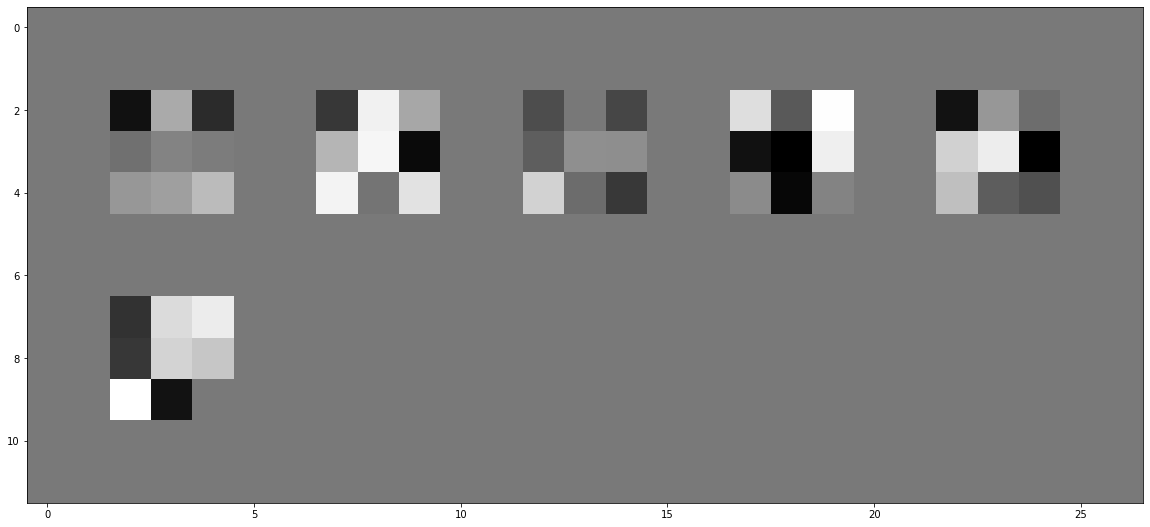

In [295]:
# Visualize weights
weights = model_weights[0]
show_images(weights, img_type='filter')

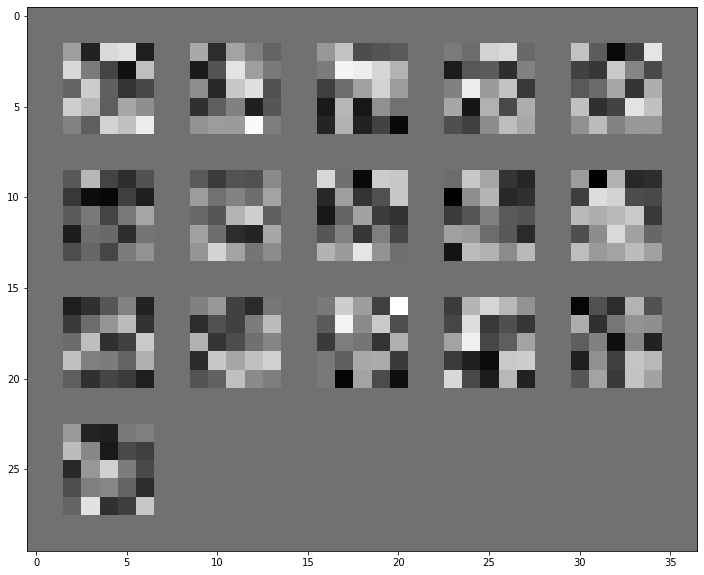

In [296]:
# Visualize weights
weights = model_weights[1]
show_images(weights, img_type='filter')

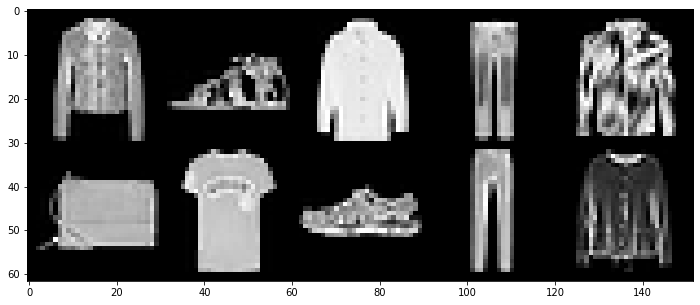

In [297]:
show_images(img)

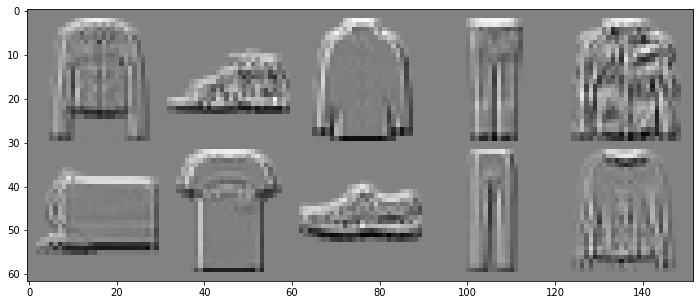

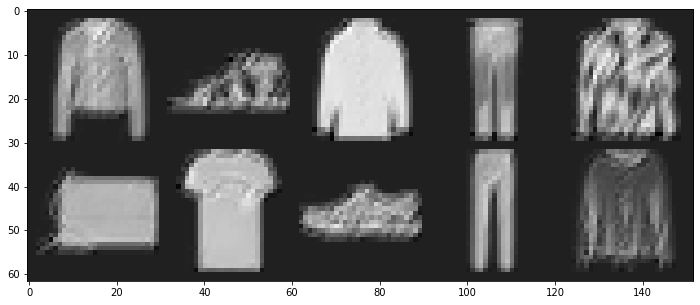

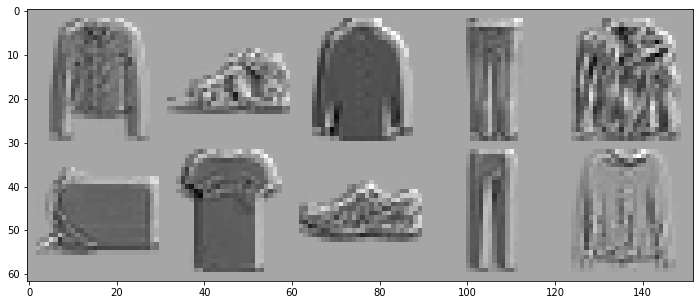

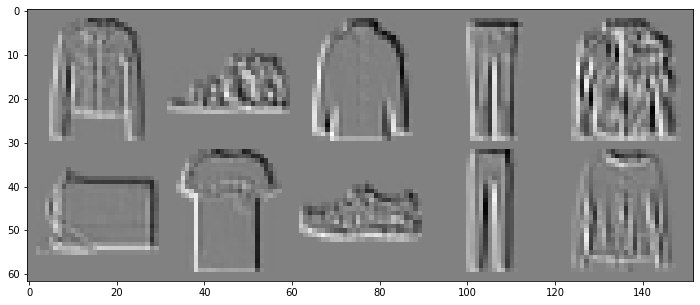

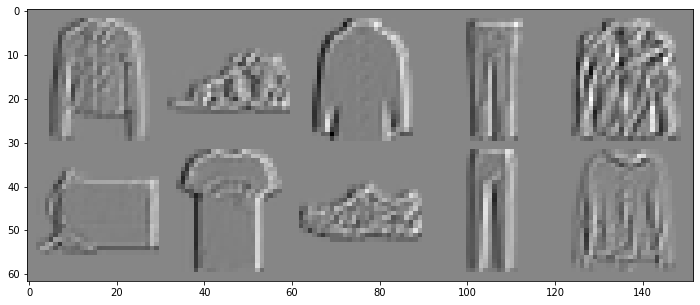

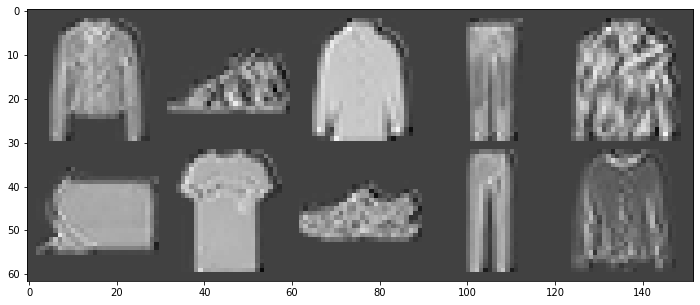

In [298]:
show_images(results[0], img_type='feature')

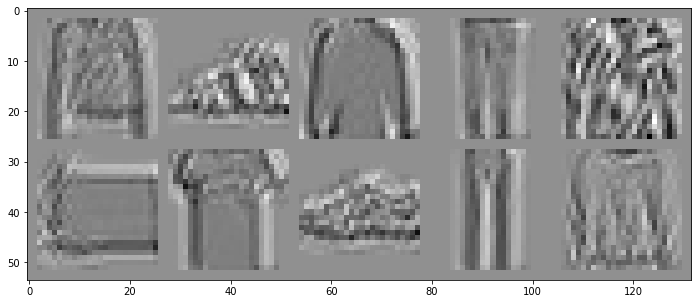

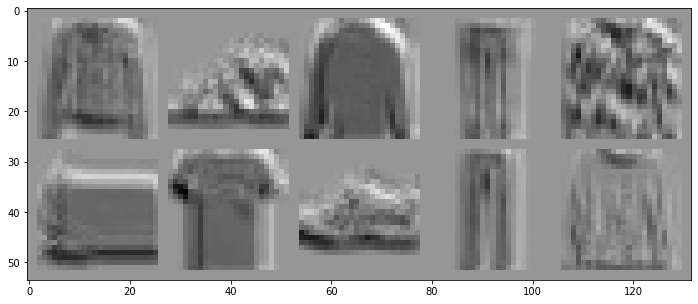

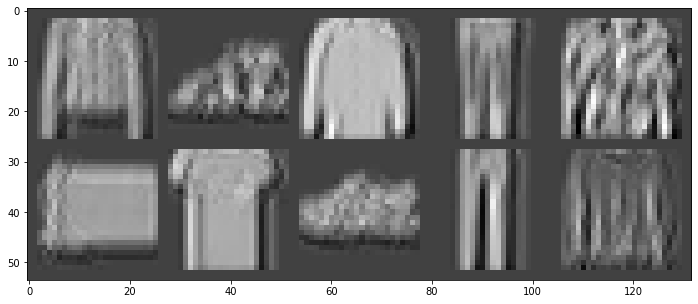

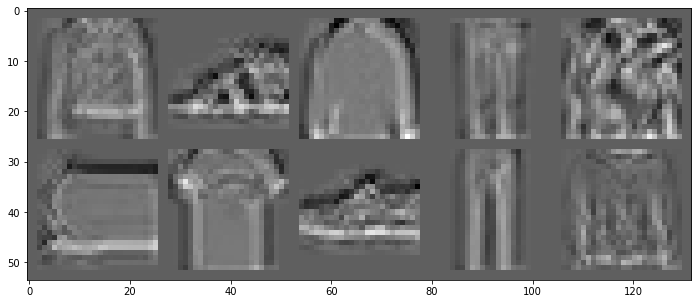

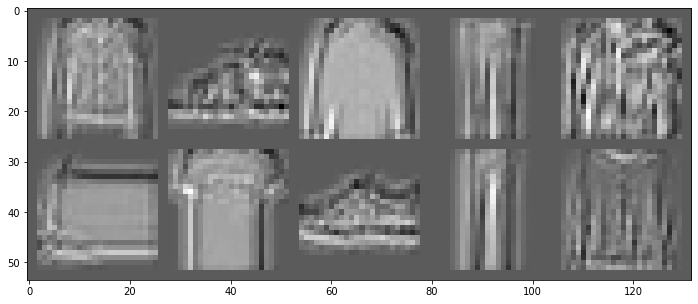

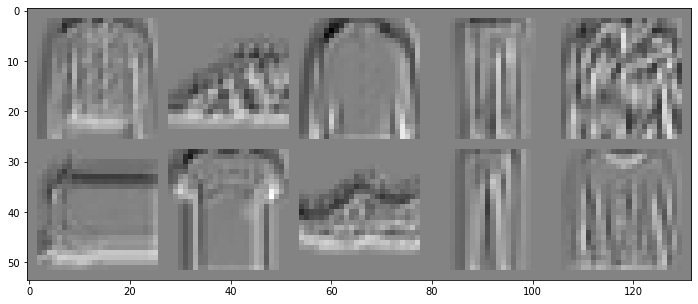

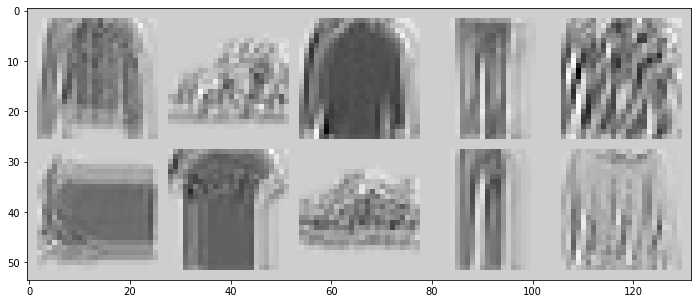

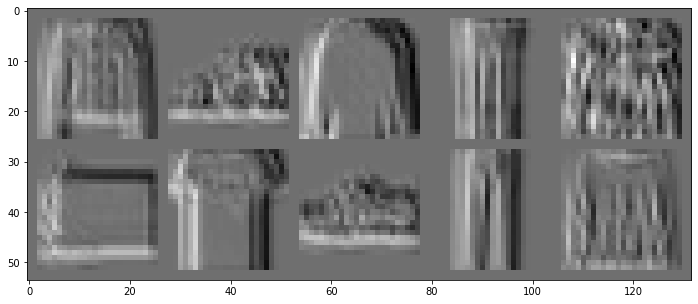

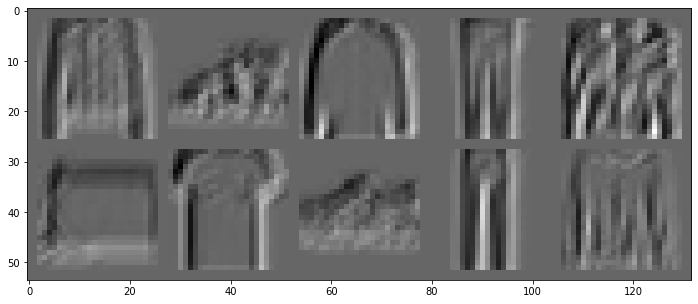

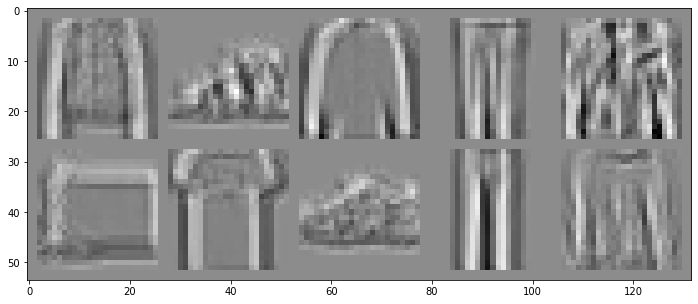

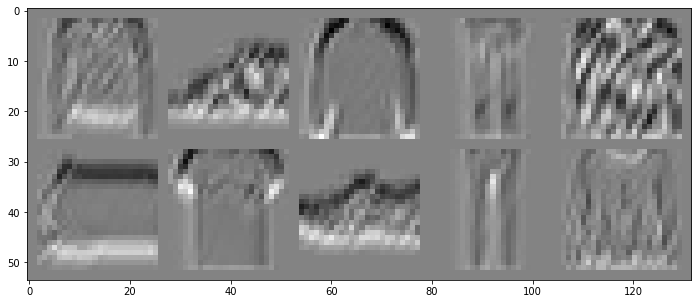

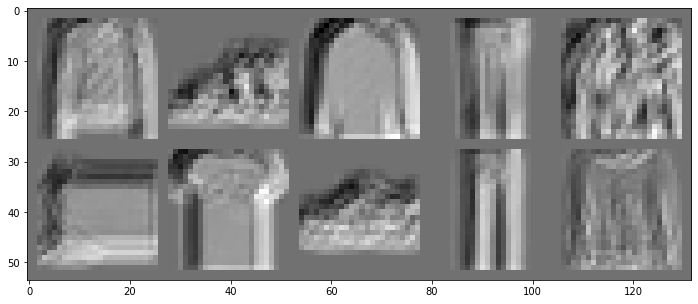

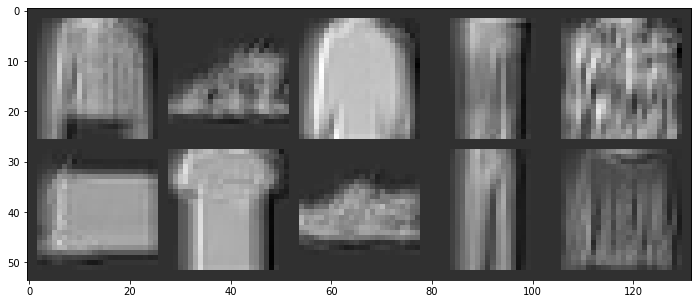

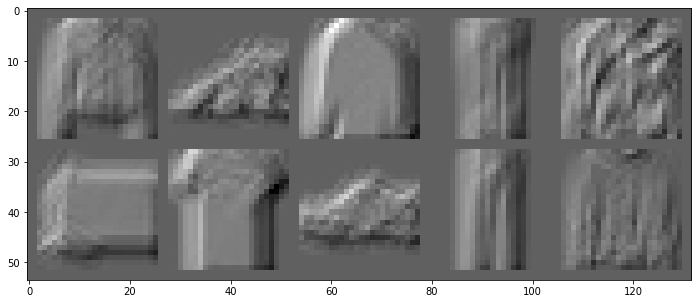

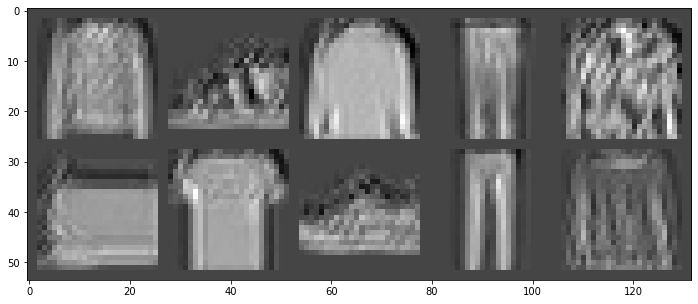

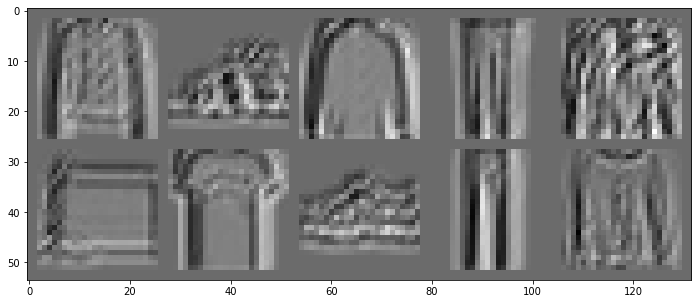

In [299]:
show_images(results[1], img_type='feature')